In [1]:
import seaborn as sns
import folium
from geopandas import GeoSeries, GeoDataFrame
import pandas as pd


from utils.downloads import (
    Censo,
    Nivel,
    download_malha
)

In [2]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Compatibilização dos setores censitários de 2010 e 2022

Com a divulgação do Censo de 2022, precisamos avaliar e compatibilizar os dados a nível de setor censitário entre este e sua última edição, de 2010.

Para essa avaliação precisaremos, primeiramente, baixar os dados georrefenciados de cada um dos censos.

# Distritos

## Download dos dados

In [3]:
distritos10 = download_malha(Censo.CENSO_2010, Nivel.DISTRITOS)
distritos10 = distritos10[distritos10['CD_GEOCODD'].str.startswith('3550308')]
distritos10.sample(3)

,ID,CD_GEOCODD,NM_DISTRIT,geometry
850,4479,355030821,CASA VERDE,"POLYGON ((-46.66236 -23.48282, -46.66234 -23.4..."
902,4531,355030873,SÃO MATEUS,"POLYGON ((-46.50207 -23.58021, -46.50207 -23.5..."
836,4465,355030807,BELA VISTA,"POLYGON ((-46.64717 -23.55161, -46.64716 -23.5..."


In [4]:
distritos22 = download_malha(Censo.CENSO_2022, Nivel.DISTRITOS, filtro='CD_MUN == "3550308"')
distritos22.sample(3)

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,T_SETORES,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
883,3,Sudeste,35,São Paulo,3550308,São Paulo,355030853,Mooca,177,80880,38364,38285,79,2.490510,10.028815,31928,"POLYGON ((-46.59882 -23.57780, -46.59714 -23.5..."
917,3,Sudeste,35,São Paulo,3550308,São Paulo,355030887,Vila Jacuí,259,134189,51896,51889,7,2.879966,17.766803,46570,"POLYGON ((-46.44362 -23.51239, -46.44357 -23.5..."
850,3,Sudeste,35,São Paulo,3550308,São Paulo,355030820,Carrão,163,84397,37987,37939,48,2.617838,11.486740,31976,"POLYGON ((-46.54096 -23.56015, -46.54055 -23.5..."


Agora, vamos conferir e compatibilizar o sistema de referências dos dois datasets.

In [5]:
distritos10.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
distritos22.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Diferente do esperado, os datasets possuem realmente sistemas de referência distintos. Vamos transpor o dataset do Censo 2022 para o mesmo sistema do Censo 2010.

In [7]:
distritos22 = distritos22.to_crs(epsg=4674)

Agora, checamos duplicidade e a quantidade de registros em cada dataset.

In [8]:
distritos10.shape

(96, 4)

In [9]:
distritos10['NM_DISTRIT'].duplicated().any()

False

In [10]:
distritos10['CD_GEOCODD'].duplicated().any()

False

In [11]:
distritos22.shape

(96, 17)

In [12]:
distritos22['NM_DIST'].duplicated().any()

False

In [13]:
distritos22['CD_DIST'].duplicated().any()

False

E checamos os tipos das colunas, em especial as colunas utilizadas como chave (`CD_GEOCODD` e `CD_DIST`) 

In [14]:
distritos10.dtypes

ID               int64
CD_GEOCODD      object
NM_DISTRIT      object
geometry      geometry
dtype: object

In [15]:
distritos22.dtypes

CD_REGIAO      object
NM_REGIAO      object
CD_UF          object
NM_UF          object
CD_MUN         object
NM_MUN         object
CD_DIST        object
NM_DIST        object
T_SETORES      object
v0001          object
v0002          object
v0003          object
v0004          object
v0005          object
v0006          object
v0007          object
geometry     geometry
dtype: object

## Cruzar codigos distritos

Avaliamos agora se os códigos se mantiveram iguais entre os dois censos.

In [16]:
distritos22['CD_DIST'].dtype

dtype('O')

In [17]:
distritos10['CD_GEOCODD'].dtype

dtype('O')

In [18]:
distritos22['CD_DIST'].str.len().unique()

array([9])

In [19]:
distritos10['CD_GEOCODD'].str.len().unique()

array([9])

In [20]:
set(distritos10['CD_GEOCODD'])-set(distritos22['CD_DIST'])

set()

In [21]:
set(distritos22['CD_DIST'])-set(distritos10['CD_GEOCODD'])

set()

E checamos se os códigos fazem referência ao distrito de mesmo nome.

In [22]:
compara_nomes = distritos22[['CD_DIST', 'NM_DIST']].merge(distritos10[['CD_GEOCODD', 'NM_DISTRIT']], left_on='CD_DIST', right_on='CD_GEOCODD')
compara_nomes

,CD_DIST,NM_DIST,CD_GEOCODD,NM_DISTRIT
0,355030801,Água Rasa,355030801,ÁGUA RASA
1,355030802,Alto de Pinheiros,355030802,ALTO DE PINHEIROS
2,355030803,Anhanguera,355030803,ANHANGUERA
3,355030804,Aricanduva,355030804,ARICANDUVA
4,355030805,Artur Alvim,355030805,ARTUR ALVIM
...,...,...,...,...
91,355030892,Vila Medeiros,355030892,VILA MEDEIROS
92,355030893,Vila Prudente,355030893,VILA PRUDENTE
93,355030894,Vila Sônia,355030894,VILA SÔNIA
94,355030895,São Domingos,355030895,SÃO DOMINGOS


In [23]:
compara_nomes['nomes_iguais'] = compara_nomes['NM_DIST'].str.lower() == compara_nomes['NM_DISTRIT'].str.lower()
compara_nomes

,CD_DIST,NM_DIST,CD_GEOCODD,NM_DISTRIT,nomes_iguais
0,355030801,Água Rasa,355030801,ÁGUA RASA,True
1,355030802,Alto de Pinheiros,355030802,ALTO DE PINHEIROS,True
2,355030803,Anhanguera,355030803,ANHANGUERA,True
3,355030804,Aricanduva,355030804,ARICANDUVA,True
4,355030805,Artur Alvim,355030805,ARTUR ALVIM,True
...,...,...,...,...,...
91,355030892,Vila Medeiros,355030892,VILA MEDEIROS,True
92,355030893,Vila Prudente,355030893,VILA PRUDENTE,True
93,355030894,Vila Sônia,355030894,VILA SÔNIA,True
94,355030895,São Domingos,355030895,SÃO DOMINGOS,True


In [24]:
compara_nomes['nomes_iguais'].all()

True

Todos os códigos de distrito se mantiveram e todos correspondem aos mesmos nomes.

## Recorte

Para checar se os poligonos dos distritos sao idênticos, vamos realizar o recorte de um poligono pelo outro. O resultado deve ser um poligono vazio

In [25]:
distritos10 = distritos10.sort_values(by='CD_GEOCODD')

In [26]:
distritos22 = distritos22.sort_values(by='CD_DIST')

Para melhorar a performance da comparação, vamos alterar o sistema de referência para um sistema projetado.

In [27]:
distritos10 = distritos10.to_crs('EPSG:31983')
distritos22 = distritos22.to_crs('EPSG:31983')

/home/vagrant/git/compatibilizacao-setores-censitarios/env/lib/python3.10/site-packages/geopandas/geodataframe.py:2467: UserWarning: `keep_geom_type=True` in overlay resulted in 430 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<Axes: >

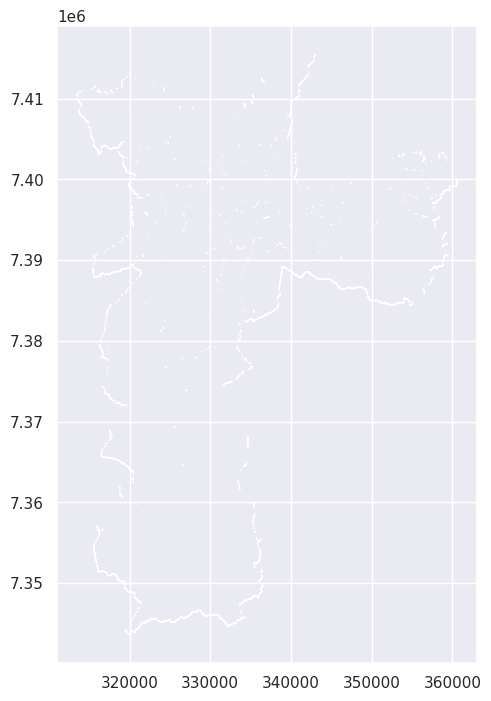

In [28]:
diferenca = distritos10.overlay(distritos22, how='difference')
diferenca.plot()

In [29]:
diferenca.geometry.area.max()

23211.461281901018

In [30]:
diferenca['area'] = diferenca.geometry.area
diferenca = diferenca.sort_values('area', ascending=False)
diferenca

,ID,CD_GEOCODD,NM_DISTRIT,geometry,area
31,4491,355030833,IGUATEMI,"MULTIPOLYGON (((355031.568 7384493.912, 355020...",2.321146e+04
52,4516,355030858,PEDREIRA,"MULTIPOLYGON (((332394.910 7378616.326, 332401...",1.436260e+04
23,4483,355030825,CIDADE TIRADENTES,"MULTIPOLYGON (((357437.586 7387598.403, 357421...",5.125604e+03
33,4494,355030836,ITAIM PAULISTA,"MULTIPOLYGON (((357381.135 7397635.182, 357381...",3.536199e+02
15,4475,355030817,CAMPO LIMPO,"MULTIPOLYGON (((320369.392 7387173.643, 320372...",2.665485e+02
...,...,...,...,...,...
45,4509,355030851,MANDAQUI,"MULTIPOLYGON (((334371.856 7402486.536, 334371...",1.639394e-10
14,4474,355030816,CAMPO GRANDE,"MULTIPOLYGON (((329548.687 7379052.610, 329548...",1.243139e-10
7,4467,355030809,BOM RETIRO,"MULTIPOLYGON (((333961.435 7396024.127, 333961...",2.901178e-11
76,4544,355030886,VILA GUILHERME,"POLYGON ((336941.354 7400522.245, 336941.354 7...",2.023414e-14


Dado que alguns distritos apresentaram diferenças, vamos definir uma tolerância (em metros quadrados) para avaliarmos visualmente.

In [31]:
tolerancia_distritos = 5**2

<Axes: >

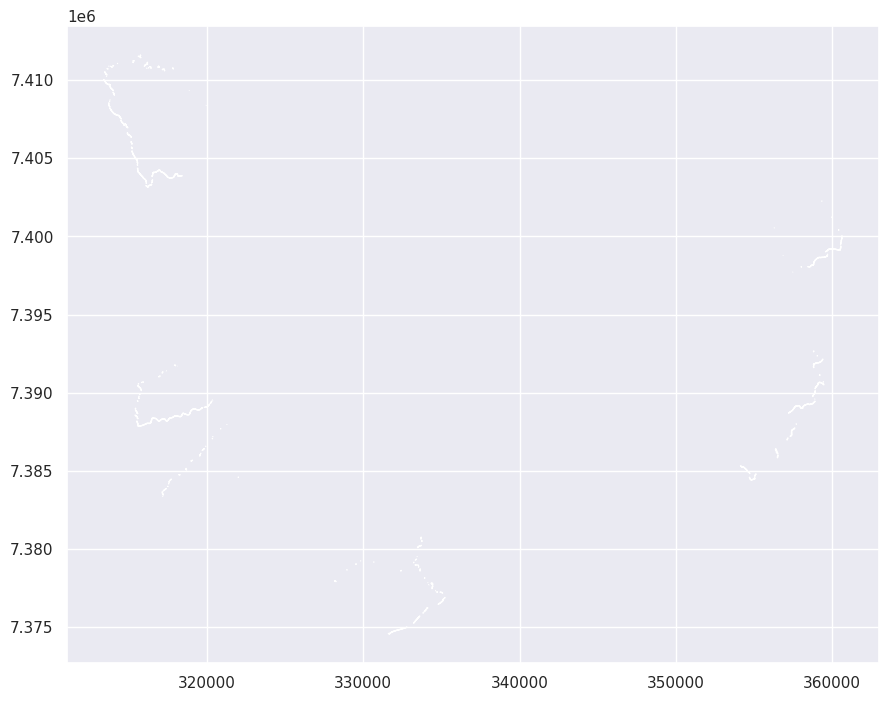

In [32]:
diferenca[diferenca.geometry.area > tolerancia_distritos].plot()

In [33]:
diferenca[diferenca.geometry.area > tolerancia_distritos].shape

(8, 5)

Apenas 8 distritos apresentaram diferenças maiores do que a tolerância atual. Vamos avaliá-los visualmente.

In [34]:
distritos_diferentes = diferenca.loc[diferenca.geometry.area > tolerancia_distritos, 'CD_GEOCODD'].tolist()
distritos_diferentes

['355030833',
 '355030858',
 '355030825',
 '355030836',
 '355030817',
 '355030865',
 '355030803',
 '355030822']

In [35]:
mapa_distritos = distritos10[distritos10['CD_GEOCODD'].isin(distritos_diferentes)].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_distritos = distritos22[distritos22['CD_DIST'].isin(distritos_diferentes)].explore(
    m=mapa_distritos,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)
mapa_distritos = diferenca[diferenca['CD_GEOCODD'].isin(distritos_diferentes)].explore(
    m=mapa_distritos,
    name='Diferença',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(mapa_distritos)  # use folium to add layer control

mapa_distritos

A inspeção visual indica que os distritos se mantiveram os mesmos, com diferenças apenas quanto a ajustes pontuais nos desenhos dos polígonos de distritos de fronteira. Para confirmar, podemos avaliar a interseção entre os distritos para confirmação.

## Proporcionalidade das geometrias


Temos 2 formas de entender as relações entre as geometrias dos dois censos. Para exemplificar, vamos supor 1 geometria (A) do censo mais recente e 2 geometrias (B e C) do censo mais antigo, sendo que A está contido em B e C, mas B e C não estão contidos em A.

Uma forma é a composição da geometria A em relação às geometrias B e C, ou seja, quanto as interseções A∩B e A∩C representam de A. Essa composição é interessante para compreendermos o setor A e os valores inferidos para ele.

A outra forma é quanto a interção A∩B representa de B e quanto a interseção A∩C representa de C. Essa forma é a que precisamos para inferirmos os valores de A no censo mais antigo, já que para o censo mais antigo possuímos apenas os valores de B e C.

As próximas seções buscam calcular essas duas formas.

### 2022 em relação a 2022

In [36]:
def prop(row:GeoSeries, other:GeoSeries|GeoDataFrame, buffer:float=-16, left_key_col:str=None, right_key_col:str=None, only_intersections:bool=True) -> GeoDataFrame:
    """
    Calcula as propriedades de interseção entre uma GeoSeries (representando uma geometria única) e uma GeoSeries (contendo uma série de geometrias) ou GeoDataFrame.

    Parâmetros:
    - row (GeoSeries): Uma GeoSeries representando a geometria para a qual as propriedades de interseção serão calculadas.
    - other (GeoSeries ou GeoDataFrame): Uma GeoSeries ou GeoDataFrame representando as geometrias com as quais 'row' será intersectada.
    - buffer (float, opcional): Distância de buffer aplicada à geometria de 'row' antes de calcular a interseção. O padrão é -16.
    - left_key_col (str, opcional): Nome da coluna em 'row' representando o valor da chave. O padrão é None.
    - right_key_col (str, opcional): Nome da coluna em 'other' representando o valor da chave. O padrão é None.
    - only_intersections (bool, opcional): Se True, retorna apenas geometrias com área de interseção não nula. O padrão é True.

    Retorna:
    - GeoDataFrame: Um GeoDataFrame contendo as propriedades de interseção, incluindo as geometrias intersectadas, área de interseção e
                    percentual da área de interseção em relação à geometria original de 'row'. Também pode incluir valores da chave de 'row' e 'other' se especificados.

    Observação:
    - Se 'other' for um GeoDataFrame, a função assume que ele contém dados de geometria na coluna 'geometry'.
    - Se 'other' for uma GeoSeries, ela será convertida em um GeoDataFrame com uma coluna 'geometry'.
    - O GeoDataFrame resultante conterá geometrias resultantes da interseção entre 'row' e 'other'.
    - A coluna 'inter_area' representa a área das geometrias de interseção.
    - A coluna 'inter_perc' representa o percentual da área de interseção em relação à área da geometria original de 'row'.
    - Se 'left_key_col' for fornecido, a coluna especificada de 'row' será incluída no GeoDataFrame resultante.
    - Se 'only_intersections' for True, o GeoDataFrame resultante conterá apenas geometrias intersectadas (onde 'inter_perc' > 0).
    """
    geom = row['geometry']
    geom = geom.buffer(buffer)
    
    if isinstance(other, GeoDataFrame):
        cols = ['geometry']
        if right_key_col:
            if right_key_col in other.columns:
                cols.insert(0, right_key_col)
        gdf = other[cols].copy()
        
    if isinstance(other, GeoSeries):
        gdf = GeoDataFrame({'geometry': other.copy()})
        gdf.set_geometry('geometry')
    gdf['geometry'] = gdf.intersection(geom)
    gdf['inter_area'] = gdf['geometry'].area
    gdf['inter_perc'] = gdf['inter_area']/geom.area
    if left_key_col:
        gdf.insert(0, left_key_col, row[left_key_col])
    if only_intersections:
        gdf = gdf[gdf['inter_perc'] > 0]
    return gdf

In [37]:
prop(distritos22.iloc[0], distritos10[['CD_GEOCODD', 'geometry']], left_key_col='CD_DIST', right_key_col='CD_GEOCODD')

,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
830,355030801,355030801,"POLYGON ((338576.322 7394456.166, 338576.401 7...",6.947573e+06,1.0


In [38]:
prop_22 = distritos22.copy()
prop_22 = prop_22.apply(lambda x: prop(x, distritos10[['CD_GEOCODD', 'geometry']], left_key_col='CD_DIST', right_key_col='CD_GEOCODD'), axis=1)
prop_22 = pd.concat(prop_22.values)
prop_22

,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
830,355030801,355030801,"POLYGON ((338576.322 7394456.166, 338576.401 7...",6.947573e+06,1.0
831,355030802,355030802,"POLYGON ((324515.178 7396038.052, 324516.085 7...",7.312988e+06,1.0
832,355030803,355030803,"MULTIPOLYGON (((313572.254 7409809.150, 313571...",3.293423e+07,1.0
833,355030804,355030804,"POLYGON ((343579.586 7392201.126, 343580.771 7...",6.661837e+06,1.0
834,355030805,355030805,"POLYGON ((346696.431 7394906.310, 346696.439 7...",6.309527e+06,1.0
...,...,...,...,...,...
921,355030892,355030892,"POLYGON ((336837.366 7400740.666, 336847.670 7...",7.674066e+06,1.0
922,355030893,355030893,"POLYGON ((337060.330 7391175.334, 337079.351 7...",9.326600e+06,1.0
923,355030894,355030894,"POLYGON ((320393.442 7389554.493, 320393.729 7...",9.826634e+06,1.0
924,355030895,355030895,"POLYGON ((319106.916 7402929.759, 319117.908 7...",9.638673e+06,1.0


Por definção, a soma do percentual de todas as interseções de um dado distrito em 2022 devem ser 1.

In [39]:
soma_22 = prop_22[['CD_DIST','inter_perc']].groupby('CD_DIST').sum()
soma_22.value_counts()

inter_perc
1.000000      7
1.000000      7
1.000000      6
1.000000      6
1.000000      5
1.000000      4
1.000000      4
1.000000      4
1.000000      4
1.000000      3
1.000000      3
1.000000      3
1.000000      3
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      1
1.000000      1
0.996369      1
0.999551      1
1.000000      1
0.999990      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
Name: count, dtype: int64


Apesar de alguns casos onde a interseção aparece com valores pouco menores do que 1, isso provavelmente se deve a erros de arredondamento no cálculo da área, já que não existe nenhuma interseção com valores próximos a 0.

Agora, vejamos se existe algum distrito de 2022 com interseção com mais de um distrito de 2010.

In [40]:
count_22 = prop_22[['CD_DIST','CD_GEOCODD']].groupby('CD_DIST').count()
count_22.value_counts()

CD_GEOCODD
1             96
Name: count, dtype: int64

Todos os setores de 2022 intersectam apenas um distrito de 2010, como esperado.

Por último, vamos inspecionar visualmente alguns distritos.

In [41]:
sample = prop_22.sample(5)
sample

,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
845,355030816,355030816,"POLYGON ((328190.135 7378104.685, 328189.072 7...",1.274220e+07,1.0
876,355030847,355030847,"POLYGON ((352494.396 7394063.624, 352495.767 7...",1.410243e+07,1.0
884,355030855,355030855,"POLYGON ((316470.045 7365780.282, 316470.806 7...",1.502478e+08,1.0
838,355030809,355030809,"POLYGON ((331769.775 7397001.280, 331767.301 7...",4.119032e+06,1.0
850,355030821,355030821,"POLYGON ((329785.690 7401057.470, 329807.309 7...",6.958673e+06,1.0


In [42]:
mapa_inter = distritos10[distritos10['CD_GEOCODD'].isin(sample['CD_GEOCODD'].unique())].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_inter = distritos22[distritos22['CD_DIST'].isin(sample['CD_DIST'].unique())].explore(
    m=mapa_inter,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)
mapa_inter = sample.explore(
    m=mapa_inter,
    name='Interseções',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(mapa_inter)  # use folium to add layer control

mapa_inter

A análise visual indica que, de fato, os distritos não tiveram modificação.

### 2022 em relação a 2010

Invertendo a ordem dos dataframes na função para a comparação, temos o quanto as interseções representam em relação aos distritos de 2010. O esperado é que todos os valores sejam 1.0 novamente.

In [43]:
prop_10 = distritos10.copy()
prop_10 = prop_10.apply(lambda x: prop(x, distritos22[['CD_DIST', 'geometry']], left_key_col='CD_GEOCODD', right_key_col='CD_DIST'), axis=1)
prop_10 = pd.concat(prop_10.values)
prop_10

,CD_GEOCODD,CD_DIST,geometry,inter_area,inter_perc
831,355030801,355030801,"POLYGON ((338576.323 7394456.166, 338576.419 7...",6.947555e+06,1.0
832,355030802,355030802,"POLYGON ((324515.178 7396038.052, 324516.085 7...",7.312109e+06,1.0
833,355030803,355030803,"MULTIPOLYGON (((313572.254 7409809.150, 313571...",3.293431e+07,1.0
834,355030804,355030804,"POLYGON ((343579.572 7392201.118, 343580.771 7...",6.661810e+06,1.0
835,355030805,355030805,"POLYGON ((346696.431 7394906.310, 346696.439 7...",6.309536e+06,1.0
...,...,...,...,...,...
922,355030892,355030892,"POLYGON ((336837.366 7400740.666, 336847.823 7...",7.674068e+06,1.0
923,355030893,355030893,"POLYGON ((337060.330 7391175.334, 337079.351 7...",9.326622e+06,1.0
924,355030894,355030894,"POLYGON ((320393.442 7389554.492, 320393.729 7...",9.826654e+06,1.0
925,355030895,355030895,"POLYGON ((319106.916 7402929.758, 319117.908 7...",9.638677e+06,1.0


In [44]:
soma_10 = prop_10[['CD_GEOCODD','inter_perc']].groupby('CD_GEOCODD').sum()
soma_10.value_counts()

inter_perc
1.000000      7
1.000000      6
1.000000      6
1.000000      6
1.000000      6
1.000000      5
1.000000      4
1.000000      4
1.000000      4
1.000000      4
1.000000      3
1.000000      3
1.000000      3
1.000000      3
1.000000      3
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      2
1.000000      1
1.000000      1
1.000000      1
1.000000      1
0.999428      1
1.000000      1
0.999782      1
1.000000      1
1.000000      1
0.999922      1
1.000000      1
Name: count, dtype: int64

Novamente, alguns valores pouco menores do que 1.0, mas nenhum valor próximo a 0, o que indica erros de arredondamento.

In [45]:
count_10 = prop_10[['CD_DIST','CD_GEOCODD']].groupby('CD_DIST').count()
count_10.value_counts()

CD_GEOCODD
1             96
Name: count, dtype: int64

A contagem novamente indica que a relação entre os distritos é de um para um.

Finalmente, uma nova inspeção visual, mas dessa vez com a interseção baseada na geometria de 2010.

In [46]:
sample = prop_10.sample(5)
sample

,CD_GEOCODD,CD_DIST,geometry,inter_area,inter_perc
855,355030825,355030825,"POLYGON ((357532.197 7387689.707, 357454.482 7...",1.457972e+07,0.999922
910,355030880,355030880,"POLYGON ((338649.568 7395716.253, 338631.258 7...",8.278078e+06,1.000000
836,355030806,355030806,"POLYGON ((327205.822 7398680.403, 327204.249 7...",5.698882e+06,1.000000
871,355030841,355030841,"POLYGON ((320332.530 7396782.625, 320491.469 7...",6.379298e+06,1.000000
918,355030888,355030888,"POLYGON ((321670.790 7397816.973, 321705.820 7...",6.815795e+06,1.000000


In [47]:
mapa_inter_2 = distritos10[distritos10['CD_GEOCODD'].isin(sample['CD_GEOCODD'].unique())].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_inter_2 = distritos22[distritos22['CD_DIST'].isin(sample['CD_DIST'].unique())].explore(
    m=mapa_inter_2,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)
mapa_inter_2 = sample.explore(
    m=mapa_inter_2,
    name='Interseções',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(mapa_inter_2)  # use folium to add layer control

mapa_inter_2


Tanto a análise de 2010 em relação a 2022, quanto a análise de 2022 em relação a 2010, indicam que os distritos se mantiveram iguais entre os censos, com poucos ajustes nas fronteiras do município, provavelmente devidos à melhor representação da geometria, mas sem alterações nas áreas mapeadas.

# Setores censitários

In [48]:
setores10 = download_malha(Censo.CENSO_2010, Nivel.SETORES, filtro='CD_GEOCODM == "3550308"')
setores10.sample(3)

,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
56124,121678.0,355030865000009,URBANO,35503086500,None,355030865,RAPOSO TAVARES,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,56125,"POLYGON ((-46.77274 -23.58771, -46.77264 -23.5..."
44850,110432.0,355030812000133,URBANO,35503081200,None,355030812,BUTANTÃ,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,44851,"POLYGON ((-46.71658 -23.58160, -46.71679 -23.5..."
55018,120542.0,355030859000048,URBANO,35503085900,None,355030859,PENHA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,55019,"POLYGON ((-46.53215 -23.52401, -46.53216 -23.5..."


In [49]:
setores22 = download_malha(Censo.CENSO_2022, Nivel.SETORES, filtro='CD_MUN == "3550308"')
setores22.sample(3)

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
79522,355030845000436P,0.002503,3,Sudeste,35,São Paulo,3550308,São Paulo,355030845,Jardim Paulista,...,3550308,São Paulo/SP,145,165,165,0,1.464646,21.212121,99,"POLYGON ((-46.67952 -23.55980, -46.67971 -23.5..."
72723,355030828000077P,0.033620,3,Sudeste,35,São Paulo,3550308,São Paulo,355030828,Ermelino Matarazzo,...,3550308,São Paulo/SP,371,152,152,0,2.748148,21.481481,135,"POLYGON ((-46.47413 -23.49106, -46.47470 -23.4..."
79785,355030846000355P,0.009386,3,Sudeste,35,São Paulo,3550308,São Paulo,355030846,Jardim São Luís,...,3550308,São Paulo/SP,289,103,103,0,2.833333,11.764706,102,"POLYGON ((-46.73887 -23.67965, -46.73888 -23.6..."


## Proporcionalidade das geometrias

### Ajustando o CRS

In [50]:
setores10 = setores10.to_crs('EPSG:31983')
setores22 = setores22.to_crs('EPSG:31983')

### 2022 em relação a 2022

In [51]:
prop(setores22.iloc[0], setores10, left_key_col='CD_SETOR', right_key_col='CD_GEOCODI')

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43400,355030801000001P,355030801000001,"POLYGON ((339758.236 7392608.386, 339719.187 7...",51070.008547,1.0


In [52]:
%%time
props_22 = setores22[:100].apply(lambda x: prop(x, setores10, left_key_col='CD_SETOR', right_key_col='CD_GEOCODI'), axis=1)
props_22 = pd.concat(props_22.values)
props_22

CPU times: user 7.64 s, sys: 4.29 ms, total: 7.65 s
Wall time: 7.69 s


,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43400,355030801000001P,355030801000001,"POLYGON ((339758.236 7392608.386, 339719.187 7...",51070.008547,1.000000
43401,355030801000002P,355030801000002,"POLYGON ((339882.154 7392783.205, 339882.070 7...",54792.361669,1.000000
43402,355030801000003P,355030801000003,"POLYGON ((340130.432 7392917.104, 340118.127 7...",35050.026331,1.000000
43403,355030801000004P,355030801000004,"POLYGON ((339851.170 7392775.204, 339870.015 7...",37232.605204,1.000000
43403,355030801000005P,355030801000004,"POLYGON ((339848.528 7392173.505, 339849.311 7...",1462.978246,0.022177
...,...,...,...,...,...
43529,355030801000130P,355030801000130,"POLYGON ((338427.822 7393814.784, 338374.251 7...",19432.028634,1.000000
43404,355030801000131P,355030801000005,"MULTIPOLYGON (((339671.062 7392162.735, 339661...",97.314206,0.001729
43405,355030801000131P,355030801000006,"POLYGON ((339630.590 7392203.832, 339619.755 7...",55748.398161,0.990490
43419,355030801000131P,355030801000020,"POLYGON ((339676.675 7392166.152, 339677.551 7...",98.150227,0.001744


In [53]:
sample_ids = props_22['CD_SETOR'].drop_duplicates().sample(100)
samples_10to22 = props_22[props_22['CD_SETOR'].isin(sample_ids)]
samples_10to22

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43400,355030801000001P,355030801000001,"POLYGON ((339758.236 7392608.386, 339719.187 7...",51070.008547,1.000000
43401,355030801000002P,355030801000002,"POLYGON ((339882.154 7392783.205, 339882.070 7...",54792.361669,1.000000
43402,355030801000003P,355030801000003,"POLYGON ((340130.432 7392917.104, 340118.127 7...",35050.026331,1.000000
43403,355030801000004P,355030801000004,"POLYGON ((339851.170 7392775.204, 339870.015 7...",37232.605204,1.000000
43403,355030801000005P,355030801000004,"POLYGON ((339848.528 7392173.505, 339849.311 7...",1462.978246,0.022177
...,...,...,...,...,...
43529,355030801000130P,355030801000130,"POLYGON ((338427.822 7393814.784, 338374.251 7...",19432.028634,1.000000
43404,355030801000131P,355030801000005,"MULTIPOLYGON (((339671.062 7392162.735, 339661...",97.314206,0.001729
43405,355030801000131P,355030801000006,"POLYGON ((339630.590 7392203.832, 339619.755 7...",55748.398161,0.990490
43419,355030801000131P,355030801000020,"POLYGON ((339676.675 7392166.152, 339677.551 7...",98.150227,0.001744


In [54]:
samples_10to22[samples_10to22['CD_SETOR'].str.endswith('131P')]

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43404,355030801000131P,355030801000005,"MULTIPOLYGON (((339671.062 7392162.735, 339661...",97.314206,0.001729
43405,355030801000131P,355030801000006,"POLYGON ((339630.590 7392203.832, 339619.755 7...",55748.398161,0.990490
43419,355030801000131P,355030801000020,"POLYGON ((339676.675 7392166.152, 339677.551 7...",98.150227,0.001744
43443,355030801000131P,355030801000044,"POLYGON ((339723.196 7392078.599, 339723.646 7...",339.802670,0.006037


In [55]:
mapa_inter_setor = setores10[setores10['CD_GEOCODI'].isin(samples_10to22['CD_GEOCODI'].unique())].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_inter_setor = setores22[setores22['CD_SETOR'].isin(samples_10to22['CD_SETOR'].unique())].explore(
    m=mapa_inter_setor,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)
mapa_inter_setor = samples_10to22.explore(
    m=mapa_inter_setor,
    name='Interseções',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(mapa_inter_setor)  # use folium to add layer control

mapa_inter_setor

### Comparação entre buffers

In [58]:
setor_exemplo = setores22[setores22['CD_SETOR'] == '355030801000131P']
setor_exemplo

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
65862,355030801000131P,0.095324,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,3550308,São Paulo/SP,858,346,346,0,2.689655,10.031348,319,"POLYGON ((339819.409 7392592.743, 339756.895 7..."


In [60]:
prop(setor_exemplo.iloc[0], setores10, left_key_col='CD_SETOR', right_key_col='CD_GEOCODI', buffer=-16)

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43404,355030801000131P,355030801000005,"MULTIPOLYGON (((339671.062 7392162.735, 339661...",97.314206,0.001729
43405,355030801000131P,355030801000006,"POLYGON ((339630.590 7392203.832, 339619.755 7...",55748.398161,0.990490
43419,355030801000131P,355030801000020,"POLYGON ((339676.675 7392166.152, 339677.551 7...",98.150227,0.001744
43443,355030801000131P,355030801000044,"POLYGON ((339723.196 7392078.599, 339723.646 7...",339.802670,0.006037


In [69]:
prop(setor_exemplo.iloc[0], setores10, left_key_col='CD_SETOR', right_key_col='CD_GEOCODI', buffer=-5)

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43404,355030801000131P,355030801000005,"POLYGON ((339682.475 7392169.684, 339668.583 7...",1352.050269,0.016355
43405,355030801000131P,355030801000006,"POLYGON ((339612.868 7392204.990, 339612.393 7...",77941.574075,0.942824
43406,355030801000131P,355030801000007,"POLYGON ((339424.498 7392394.111, 339431.096 7...",60.555958,0.000733
43419,355030801000131P,355030801000020,"POLYGON ((339691.156 7392132.124, 339682.044 7...",843.129561,0.010199
43443,355030801000131P,355030801000044,"POLYGON ((339682.044 7392134.572, 339691.156 7...",2470.920166,0.029890


In [64]:
prop(setor_exemplo.iloc[0], setores10, left_key_col='CD_SETOR', right_key_col='CD_GEOCODI', buffer=0)

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43400,355030801000131P,355030801000001,"MULTIPOLYGON (((339767.580 7392591.687, 339764...",1.024904e+02,1.075355e-03
43404,355030801000131P,355030801000005,"MULTIPOLYGON (((339650.838 7392494.496, 339650...",1.904849e+03,1.998614e-02
43405,355030801000131P,355030801000006,"POLYGON ((339456.132 7392739.111, 339527.332 7...",8.568325e+04,8.990098e-01
43406,355030801000131P,355030801000007,"POLYGON ((339412.936 7392675.288, 339418.487 7...",2.366022e+03,2.482489e-02
43409,355030801000131P,355030801000010,"POLYGON ((339456.132 7392739.111, 339456.132 7...",6.096384e-09,6.396477e-14
43419,355030801000131P,355030801000020,"POLYGON ((339691.156 7392132.124, 339682.044 7...",1.137063e+03,1.193035e-02
43420,355030801000131P,355030801000021,"POLYGON ((339609.505 7392205.210, 339627.626 7...",6.414241e+02,6.729980e-03
43443,355030801000131P,355030801000044,"POLYGON ((339707.088 7392038.384, 339705.094 7...",3.473371e+03,3.644346e-02
